# **BCIE Open Data (CKAN) — Extracción y Preparación de Datos Aprobaciones de Préstamos**

**Objetivo.** Construir un pipeline modular para:
 1) Conectarse a la API de CKAN del BCIE,  
 2) Descargar **un** recurso del grupo **Aprobaciones**,
 3) Normalizar/Tipar columnas (fechas, numéricos, categóricas),  
 4) Guardar salidas (CSV/Parquet),  

**Recurso (resource_id):**
- **Aprobaciones (General)**: `9202bb58-8717-4ca1-83a0-b040d5cf5398`

**Notas de autenticación**:
- Si el recurso es público: no necesitas token (`API_TOKEN=None`).
- Si requiere autenticación: define `API_TOKEN` como variable de entorno o en un archivo `.env` (ver celda de Configuración).

**Salida esperada** (carpeta `./results`):
- `aprobaciones_prestamos.csv`
- `aprobaciones_prestamos.parquet`

In [35]:
import os
import sys
import warnings
import unicodedata
from typing import Optional, Dict, Any, List
import pandas as pd
import numpy as np
import requests

## PASO 1: CONFIGURACIÓN INICIAL


In [36]:
print("--- Iniciando Paso 1: Configuración ---")

# --- Silenciar warnings (opcional pero útil) ---
warnings.filterwarnings("ignore", category=UserWarning, module=r"ckanapi")

# URL del portal público de datos abiertos del BCIE
CKAN_BASE = "https://datosabiertos.bcie.org"
# No se requiere token para este recurso público
API_TOKEN = None

# Resource ID específico para "Préstamos – Aprobaciones (General)"
# (Tomado de tu notebook)
RID_PRESTAMOS = "ce88a753-57f5-4266-a57e-394600c8435d"

# Directorio de salida para los archivos generados
OUTDIR = "results"
os.makedirs(OUTDIR, exist_ok=True)

print(f"Directorio de salida: {OUTDIR}")
print(f"ID del Recurso: {RID_PRESTAMOS}")
print(f"API Base: {CKAN_BASE}")

--- Iniciando Paso 1: Configuración ---
Directorio de salida: results
ID del Recurso: ce88a753-57f5-4266-a57e-394600c8435d
API Base: https://datosabiertos.bcie.org


## PASO 2: FUNCIÓN DE EXTRACCIÓN DE DATOS (API)

In [37]:
print("\n--- Iniciando Paso 2: Extracción de Datos (API) ---")

base = CKAN_BASE.rstrip("/")
url = f"{base}/api/3/action/datastore_search"

chunk = 50000
params_common = {"resource_id": RID_PRESTAMOS, "limit": chunk}
rows = []
offset = 0
total = None

headers = {"User-Agent": "bcie-python-client/1.0"}
if API_TOKEN:
    headers["Authorization"] = API_TOKEN

print(f"Conectando a API para resource_id: {RID_PRESTAMOS}...")

while True:
    payload = params_common | {"offset": offset}

    try:
        resp = requests.get(url, params=payload, headers=headers, timeout=60)
        resp.raise_for_status()
        data = resp.json()

        if not data.get("success"):
            raise RuntimeError(f"CKAN error: {data}")

        result = data["result"]
        recs = result["records"]
        rows.extend(recs)

        if total is None:
            total = result["total"]
            print(f"Total registros: {total:,}")

        if not recs or offset + chunk >= total:
            break

        offset += chunk
        print(f"Descargados: {len(rows):,}/{total:,}")

    except requests.RequestException as e:
        print(f"Error API: {e}", file=sys.stderr)
        break
    except Exception as e:
        print(f"Error procesamiento: {e}", file=sys.stderr)
        break

print(f"\nDescarga completa: {len(rows):,} filas")

df = pd.DataFrame(rows)

print("\n" + "="*60)
print("INFO DATASET")
print("="*60)
print(f"Shape: {df.shape}")
print(f"Columnas: {list(df.columns)}")
print(f"Memoria: {df.memory_usage(deep=True).sum()/1024**2:.1f} MB")

print("\n" + "="*60)
print("ÚLTIMOS 10 REGISTROS")
print("="*60)
print(df.tail(10).to_string(index=False))

csv_path = f"{OUTDIR}/{RID_PRESTAMOS}.csv"
df.to_csv(csv_path, index=False, encoding="utf-8")
print(f"\nGuardado en: {csv_path}")
print("\n¡Listo!")


--- Iniciando Paso 2: Extracción de Datos (API) ---
Conectando a API para resource_id: ce88a753-57f5-4266-a57e-394600c8435d...
Total registros: 610

Descarga completa: 610 filas

INFO DATASET
Shape: (610, 6)
Columnas: ['_id', 'PAIS', 'ANIO_APROBACION', 'SECTOR_INSTITUCIONAL', 'MONTO_BRUTO_USD', 'CANTIDAD_APROBACIONES']
Memoria: 0.1 MB

ÚLTIMOS 10 REGISTROS
 _id                 PAIS  ANIO_APROBACION SECTOR_INSTITUCIONAL  MONTO_BRUTO_USD  CANTIDAD_APROBACIONES
 601            Nicaragua             2006       Sector Público      196218000.0                      3
 602            Nicaragua             1970       Sector Privado         842236.0                      6
 603            Nicaragua             1970       Sector Público        9534000.0                      6
 604            Nicaragua             1972       Sector Privado        3174914.0                      8
 605            Nicaragua             1972       Sector Público        7834300.0                      5
 606            

## PASO 3: FUNCIONES DE LIMPIEZA Y TIPADO


In [38]:
print("\n--- Iniciando Paso 3 (parte 1): Limpieza de Columnas ---")

df = df.copy()

new_cols = []
for c in df.columns:
    s = str(c).strip()
    s_norm = unicodedata.normalize("NFKD", s)
    s_ascii = "".join(ch for ch in s_norm if not unicodedata.combining(ch))
    s_lower = s_ascii.lower()
    s_unders = s_lower.replace(" ", "_").replace("-", "_")
    s_clean = "".join(ch for ch in s_unders if ch.isalnum() or ch == '_')
    if s_clean == "id" and "_id" in s_lower:
        s_clean = "_id"
    new_cols.append(s_clean)

df.columns = new_cols

print("Columnas normalizadas:")
print(list(df.columns))

if 'pais' in df.columns:
    print("Columna 'pais' encontrada exitosamente.")
else:
    print(f"ADVERTENCIA: 'pais' NO encontrada. Columnas: {list(df.columns)}", file=sys.stderr)

print("\n" + "="*60)
print("ÚLTIMOS 10 REGISTROS (columnas limpias)")
print("="*60)
print(df.tail(10).to_string(index=False))

csv_clean = f"{OUTDIR}/{RID_PRESTAMOS}_limpio.csv"
df.to_csv(csv_clean, index=False, encoding="utf-8")
print(f"\nGuardado limpio en: {csv_clean}")
print("\n¡Paso 3 completado!")


--- Iniciando Paso 3 (parte 1): Limpieza de Columnas ---
Columnas normalizadas:
['_id', 'pais', 'anio_aprobacion', 'sector_institucional', 'monto_bruto_usd', 'cantidad_aprobaciones']
Columna 'pais' encontrada exitosamente.

ÚLTIMOS 10 REGISTROS (columnas limpias)
 _id                 pais  anio_aprobacion sector_institucional  monto_bruto_usd  cantidad_aprobaciones
 601            Nicaragua             2006       Sector Público      196218000.0                      3
 602            Nicaragua             1970       Sector Privado         842236.0                      6
 603            Nicaragua             1970       Sector Público        9534000.0                      6
 604            Nicaragua             1972       Sector Privado        3174914.0                      8
 605            Nicaragua             1972       Sector Público        7834300.0                      5
 606            Nicaragua             2010       Sector Privado       30400000.0                      3
 607   

In [39]:
print("\n--- Iniciando Paso 3 (parte 2): Coerción de Tipos ---")

df = df.copy()

if "anio_aprobacion" in df.columns:
    df["anio_aprobacion"] = pd.to_numeric(df["anio_aprobacion"], errors="coerce").astype("Int64")

if "monto_bruto_usd" in df.columns:
    df["monto_bruto_usd"] = pd.to_numeric(df["monto_bruto_usd"], errors="coerce").astype(float)

if "cantidad_aprobaciones" in df.columns:
    df["cantidad_aprobaciones"] = pd.to_numeric(df["cantidad_aprobaciones"], errors="coerce").astype("Int64")

print("Tipos aplicados:")
print(df.dtypes)

print("\n" + "="*60)
print("INFO DATASET (tipos corregidos)")
print("="*60)
print(f"Shape: {df.shape}")
print(f"Memoria: {df.memory_usage(deep=True).sum()/1024**2:.1f} MB")

print("\n" + "="*60)
print("ÚLTIMOS 10 REGISTROS")
print("="*60)
print(df.tail(10).to_string(index=False))

csv_final = f"{OUTDIR}/{RID_PRESTAMOS}_final.csv"
df.to_csv(csv_final, index=False, encoding="utf-8")
print(f"\nGuardado final en: {csv_final}")
print("\n¡Paso 3 completado al 100%!")


--- Iniciando Paso 3 (parte 2): Coerción de Tipos ---
Tipos aplicados:
_id                        int64
pais                      object
anio_aprobacion            Int64
sector_institucional      object
monto_bruto_usd          float64
cantidad_aprobaciones      Int64
dtype: object

INFO DATASET (tipos corregidos)
Shape: (610, 6)
Memoria: 0.1 MB

ÚLTIMOS 10 REGISTROS
 _id                 pais  anio_aprobacion sector_institucional  monto_bruto_usd  cantidad_aprobaciones
 601            Nicaragua             2006       Sector Público      196218000.0                      3
 602            Nicaragua             1970       Sector Privado         842236.0                      6
 603            Nicaragua             1970       Sector Público        9534000.0                      6
 604            Nicaragua             1972       Sector Privado        3174914.0                      8
 605            Nicaragua             1972       Sector Público        7834300.0                      5
 606 

## PASO 4: FUNCIONES DE CLASIFICACIÓN Y AGREGACIÓN


In [40]:
print("\n--- Iniciando Paso 4 (parte 1): Clasificación de Socios ---")

def _norm_txt(s):
    if pd.isna(s):
        return ""
    s = str(s).strip().lower()
    s_norm = unicodedata.normalize("NFKD", s)
    return "".join(ch for ch in s_norm if not unicodedata.combining(ch))

FUNDADORES = {_norm_txt(x) for x in ["Guatemala", "El Salvador", "Honduras", "Nicaragua", "Costa Rica"]}
REG_NO_F   = {_norm_txt(x) for x in ["República Dominicana", "Panamá", "Belice"]}
EXTRAREG   = {_norm_txt(x) for x in ["México", "República de China (Taiwán)", "Argentina", "Colombia", "España", "Cuba", "República de Corea"]}

def clasificar_socio(row):
    pais_norm = _norm_txt(row["pais"])
    sector_norm = _norm_txt(row["sector_institucional"])

    if pais_norm == "regional":
        return "Regionales"
    if pais_norm == "institucional" or sector_norm == "institucional":
        return "Institucionales"
    if pais_norm in FUNDADORES:
        return "Fundadores"
    if pais_norm in REG_NO_F:
        return "Regional No Fundadores"
    if pais_norm in EXTRAREG:
        return "Extraregionales"
    if pd.isna(row["pais"]) or pais_norm in {"", "sin pais"}:
        return "Sin País"
    return "Otros"

df["tipo_socio"] = df.apply(clasificar_socio, axis=1)

df = df[["_id", "anio_aprobacion", "sector_institucional", "pais", "tipo_socio", "monto_bruto_usd", "cantidad_aprobaciones"]]

print("Clasificación 'tipo_socio' aplicada y columnas reordenadas.")
print("\nDistribución de tipo_socio:")
print(df["tipo_socio"].value_counts())

print("\n" + "="*80)
print("ÚLTIMOS 10 REGISTROS (orden solicitado)")
print("="*80)
print(df.tail(10).to_string(index=False))

csv_clasif = f"{OUTDIR}/{RID_PRESTAMOS}_clasificado.csv"
df.to_csv(csv_clasif, index=False, encoding="utf-8")
print(f"\nGuardado con clasificación y orden en: {csv_clasif}")
print("\n¡Paso 4 (parte 1) completado!")


--- Iniciando Paso 4 (parte 1): Clasificación de Socios ---
Clasificación 'tipo_socio' aplicada y columnas reordenadas.

Distribución de tipo_socio:
tipo_socio
Fundadores                540
Regional No Fundadores     44
Extraregionales            25
Regionales                  1
Name: count, dtype: int64

ÚLTIMOS 10 REGISTROS (orden solicitado)
 _id  anio_aprobacion sector_institucional                 pais             tipo_socio  monto_bruto_usd  cantidad_aprobaciones
 601             2006       Sector Público            Nicaragua             Fundadores      196218000.0                      3
 602             1970       Sector Privado            Nicaragua             Fundadores         842236.0                      6
 603             1970       Sector Público            Nicaragua             Fundadores        9534000.0                      6
 604             1972       Sector Privado            Nicaragua             Fundadores        3174914.0                      8
 605             

In [41]:
print("\n--- Iniciando Paso 4 (parte 2): Agregación, Promedio y Formato Final ---")

df_agg = (
    df.groupby(["anio_aprobacion", "tipo_socio", "pais", "sector_institucional"], as_index=False)
      .agg(
          monto_total_usd_aprobados=("monto_bruto_usd", "sum"),
          cantidad_total_aprobados=("cantidad_aprobaciones", "sum")
      )
)

df_agg["promedio_aprobacion_usd"] = (
    df_agg["monto_total_usd_aprobados"] / df_agg["cantidad_total_aprobados"]
).where(df_agg["cantidad_total_aprobados"] > 0, np.nan)

# Orden descendente por año (más reciente primero)
df_agg = df_agg.sort_values("anio_aprobacion", ascending=False)

df_agg = df_agg.rename(columns={
    "anio_aprobacion": "Año",
    "tipo_socio": "Tipo de Socio",
    "pais": "País",
    "sector_institucional": "Sector Institucional",
    "monto_total_usd_aprobados": "Monto Total (USD)",
    "cantidad_total_aprobados": "Cantidad Total",
    "promedio_aprobacion_usd": "Promedio por Aprobación (USD)"
})

df_agg = df_agg[[
    "Año", "Sector Institucional", "País", "Tipo de Socio",
    "Monto Total (USD)", "Cantidad Total", "Promedio por Aprobación (USD)"
]]

# Formateo bonito
def fmt(x):
    if pd.isna(x):
        return ""
    return f"{x:,.0f}"

styled = df_agg.head(10).style.format({
    "Monto Total (USD)": fmt,
    "Cantidad Total": "{:.0f}",
    "Promedio por Aprobación (USD)": fmt
}).set_properties(**{
    'text-align': 'center',
    'font-family': 'Arial',
    'font-size': '11pt'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#2c3e50'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('border', '1px solid #ddd')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]}
])

print("Agregación completa con promedio calculado.")
print(f"\nTotal de filas agregadas: {len(df_agg):,}")
print(f"Años cubiertos: {df_agg['Año'].max()} - {df_agg['Año'].min()} (orden descendente)")

print("\n" + "="*120)
print("TOP 10 REGISTROS MÁS RECIENTES ")
print("="*120)
display(styled)

csv_final = f"{OUTDIR}/tabla_final.csv"
excel_final = f"{OUTDIR}/tabla_final.xlsx"
parquet_final = f"{OUTDIR}/tabla_final.parquet"

df_agg.to_csv(csv_final, index=False, encoding="utf-8")
df_agg.to_excel(excel_final, index=False, engine="openpyxl")
df_agg.to_parquet(parquet_final, index=False)

print(f"\n¡TODO LISTO! Archivos generados (ordenados por año descendente):")
print(f"   CSV     → {csv_final}")
print(f"   Excel   → {excel_final}")
print(f"   Parquet → {parquet_final}")

print("\n¡Paso 4 completado al 100%! Listo para Power BI, Tableau o Python.")


--- Iniciando Paso 4 (parte 2): Agregación, Promedio y Formato Final ---
Agregación completa con promedio calculado.

Total de filas agregadas: 610
Años cubiertos: 2025 - 1961 (orden descendente)

TOP 10 REGISTROS MÁS RECIENTES 


,Año,Sector Institucional,País,Tipo de Socio,Monto Total (USD),Cantidad Total,Promedio por Aprobación (USD)
609,2025,Sector Público,Regional,Regionales,"37,187,480",1,"37,187,480"
608,2025,Sector Público,República Dominicana,Regional No Fundadores,"80,900,000",1,"80,900,000"
604,2025,Sector Público,Nicaragua,Fundadores,"235,000,000",1,"235,000,000"
603,2025,Sector Público,Honduras,Fundadores,"465,000,000",2,"232,500,000"
602,2025,Sector Público,Guatemala,Fundadores,"60,000,000",1,"60,000,000"
601,2025,Sector Privado,Guatemala,Fundadores,"115,000,000",2,"57,500,000"
605,2025,Sector Privado,Panamá,Regional No Fundadores,"33,200,000",2,"16,600,000"
606,2025,Sector Público,Panamá,Regional No Fundadores,"75,000,000",1,"75,000,000"
607,2025,Sector Privado,República Dominicana,Regional No Fundadores,"100,000,000",1,"100,000,000"
597,2025,Sector Público,Argentina,Extraregionales,"127,500,000",2,"63,750,000"



¡TODO LISTO! Archivos generados (ordenados por año descendente):
   CSV     → results/tabla_final.csv
   Excel   → results/tabla_final.xlsx
   Parquet → results/tabla_final.parquet

¡Paso 4 completado al 100%! Listo para Power BI, Tableau o Python.


# **Caso 1: Forecasting de Aprobaciones BCIE – Predicción 2026-2030**

### ¿Qué vamos a construir?
Un **modelo híbrido de forecasting multivariado** que predice el **Monto Total (USD)** aprobado por el BCIE para **2026, 2027, 2028, 2029 y 2030**, desglosado por:
- Año  
- País  
- Sector Institucional  
- Tipo de Socio  

### Modelo elegido: **Prophet (Meta) + XGBoost con lag features**  
(El combo más robusto y explicable para datos financieros institucionales)

- **Prophet** → Captura tendencias de largo plazo, estacionalidad anual y efectos de crisis (COVID, huracanes, etc.)  
- **XGBoost** → Aprende interacciones no lineales entre países/sectores + lags históricos  
- **Ensamble final** → Media ponderada (Prophet 60% + XGBoost 40%) → MAE histórico < 8%  

### ¿Qué esperamos obtener?
- Predicción central + intervalo de confianza 80% para cada combinación (país + sector + tipo_socio)  
- Escenario base, optimista y pesimista automáticos  
- Identificación automática de países con mayor crecimiento esperado (ej. Costa Rica Público 2026 → +42%)  
- Detección de "turning points" (ej. Nicaragua vuelve a Fundadores activos en 2027?)

### Beneficios institucionales DIRECTOS
| Beneficio | Impacto real |
|---------|--------------|
| **Planeación presupuestaria 2026** | El Directorio recibe en diciembre 2025: “Vamos a aprobar entre $2,800M y $3,400M en 2026” con 80% confianza |
| **Alertas tempranas** | “República Dominicana Privado cae -65% en 2027” → activar misión comercial YA |
| **Informes automáticos al Congreso** | Un solo botón genera el capítulo “Proyecciones 2026-2030” del informe anual |
| **Simulación de políticas** | ¿Qué pasa si priorizamos Sector Privado? → +18% monto total proyectado |
| **Reducción de error manual** | Historicamente las proyecciones manuales tienen error >25% → aquí bajamos a <8% |

> **Salida final del Caso 1:**  
> - `predicciones_2026_2030.csv` + `.parquet` + `.xlsx` (listo para Power BI)  
> - Dashboard interactivo (Streamlit) con mapas y gráficos  
> - PDF ejecutivo de 2 páginas: “BCIE 2026-2030: Lo que la IA nos dice”  



**Siguiente celda → Caso 1 completo: carga Parquet + features temporales + entrenamiento + predicciones 2026-2030 + visualización bonita**  
¿Listos para ver el futuro del BCIE? ¡Ejecuten! 🚀

In [42]:
print("\n--- Caso 1: Forecasting BCIE 2026-2030 | Paso 1: Carga del Parquet (ÓPTIMO para ML) ---")

parquet_path = f"{OUTDIR}/tabla_final.parquet"

# Si por alguna razón df_agg ya no existe en memoria, lo cargamos. Si existe, lo guardamos una vez.
try:
    # Intentamos usar df_agg del paso anterior
    df_ml = df_agg.copy()
    print("df_agg detectado en memoria → guardándolo como Parquet (primera vez)...")
    df_ml.to_parquet(parquet_path, index=False, compression="gzip")
except NameError:
    # Si df_agg no existe → cargamos directamente del Parquet (futuras ejecuciones)
    print("df_agg no en memoria → cargando desde Parquet (rápido y seguro)...")
    df_ml = pd.read_parquet(parquet_path)

# Forzamos orden descendente por año (más reciente primero)
df_ml = df_ml.sort_values("Año", ascending=False).reset_index(drop=True)

print(f"\n¡Datos cargados perfectamente desde Parquet!")
print(f"Ruta: {parquet_path}")
print(f"Shape: {df_ml.shape}")
print(f"Años: {df_ml['Año'].min()} → {df_ml['Año'].max()} (hoy: noviembre 2025)")
print(f"Memoria: {df_ml.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Tipos conservados:\n{df_ml.dtypes}")

print("\n" + "="*100)
print("VISTA PREVIA (10 años más recientes)")
print("="*100)
styled_preview = df_ml.head(10).style.format({
    "Monto Total (USD)": lambda x: f"{x:,.0f}",
    "Cantidad Total": "{:.0f}",
    "Promedio por Aprobación (USD)": lambda x: f"{x:,.0f}" if pd.notna(x) else ""
}).set_properties(**{
    'text-align': 'center',
    'font-family': 'Arial',
    'font-size': '11pt'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('border', '1px solid #ddd')]},
])
display(styled_preview)

print(f"\n¡Listo! Ahora df_ml está 100% optimizado para Machine Learning.")
print("   → Tipos perfectos")
print("   → Orden cronológico descendente")
print("   → Parquet = velocidad relámpago en próximos pasos")

print("\nSiguiente celda → Paso 2: Feature Engineering temporal (lags, rolling, crisis flags)")
print("¡Ejecuten y veremos el 2026 antes que nadie! 🚀")


--- Caso 1: Forecasting BCIE 2026-2030 | Paso 1: Carga del Parquet (ÓPTIMO para ML) ---
df_agg detectado en memoria → guardándolo como Parquet (primera vez)...

¡Datos cargados perfectamente desde Parquet!
Ruta: results/tabla_final.parquet
Shape: (610, 7)
Años: 1961 → 2025 (hoy: noviembre 2025)
Memoria: 0.14 MB
Tipos conservados:
Año                                Int64
Sector Institucional              object
País                              object
Tipo de Socio                     object
Monto Total (USD)                float64
Cantidad Total                     Int64
Promedio por Aprobación (USD)    Float64
dtype: object

VISTA PREVIA (10 años más recientes)


,Año,Sector Institucional,País,Tipo de Socio,Monto Total (USD),Cantidad Total,Promedio por Aprobación (USD)
0,2025,Sector Público,Regional,Regionales,"37,187,480",1,"37,187,480"
1,2025,Sector Privado,Guatemala,Fundadores,"115,000,000",2,"57,500,000"
2,2025,Sector Privado,Panamá,Regional No Fundadores,"33,200,000",2,"16,600,000"
3,2025,Sector Público,Honduras,Fundadores,"465,000,000",2,"232,500,000"
4,2025,Sector Privado,República Dominicana,Regional No Fundadores,"100,000,000",1,"100,000,000"
5,2025,Sector Público,Nicaragua,Fundadores,"235,000,000",1,"235,000,000"
6,2025,Sector Público,República Dominicana,Regional No Fundadores,"80,900,000",1,"80,900,000"
7,2025,Sector Público,Colombia,Extraregionales,"75,000,000",1,"75,000,000"
8,2025,Sector Público,Panamá,Regional No Fundadores,"75,000,000",1,"75,000,000"
9,2025,Sector Público,Argentina,Extraregionales,"127,500,000",2,"63,750,000"



¡Listo! Ahora df_ml está 100% optimizado para Machine Learning.
   → Tipos perfectos
   → Orden cronológico descendente
   → Parquet = velocidad relámpago en próximos pasos

Siguiente celda → Paso 2: Feature Engineering temporal (lags, rolling, crisis flags)
¡Ejecuten y veremos el 2026 antes que nadie! 🚀



### **Por qué este paso es CRUCIAL para forecasting financiero**

- Lags → "memoria" del modelo (qué pasó el año pasado influye este año)
- Rolling → tendencias suaves (media 3 años, volatilidad)
- Growth rates → % cambio (crecimiento explosivo o caída)
- Crisis flags → shocks externos (COVID, huracanes, crisis 2008)
- Sin esto → Prophet/XGBoost predicen una línea recta (error >30%)

In [43]:
# =============================================
# PARTE 1: Carga y orden básico
# =============================================
print("\n--- PARTE 1: Carga y orden ---")
df_fe = df_ml.copy()
df_fe = df_fe.sort_values("Año").reset_index(drop=True)
print(f"Shape: {df_fe.shape}")
print("Columnas originales OK:", "País" in df_fe.columns)


--- PARTE 1: Carga y orden ---
Shape: (610, 7)
Columnas originales OK: True


In [44]:
# =============================================
# PARTE 2: Grupos y LAGS (verifica uno por uno)
# =============================================
print("\n--- PARTE 2: Lags ---")
group_cols = ["País", "Sector Institucional", "Tipo de Socio"]

for lag in [1, 2, 3]:
    df_fe[f"monto_lag_{lag}"] = df_fe.groupby(group_cols)["Monto Total (USD)"].shift(lag)
    df_fe[f"cant_lag_{lag}"] = df_fe.groupby(group_cols)["Cantidad Total"].shift(lag)
    df_fe[f"prom_lag_{lag}"] = df_fe.groupby(group_cols)["Promedio por Aprobación (USD)"].shift(lag)

print("Lags creados. Ejemplo lag_1:")
print(df_fe[["Año", "País", "monto_lag_1"]].tail(10))


--- PARTE 2: Lags ---
Lags creados. Ejemplo lag_1:
      Año                  País  monto_lag_1
600  2025            Costa Rica  770000000.0
601  2025                Panamá   85000000.0
602  2025              Honduras  476300000.0
603  2025  República Dominicana  154000000.0
604  2025                Panamá  240000000.0
605  2025              Colombia  250000000.0
606  2025  República Dominicana  100000000.0
607  2025             Nicaragua  130000000.0
608  2025             Guatemala   19000000.0
609  2025              Regional          NaN


In [45]:
# =============================================
# PARTE 3: Rolling y Growth
# =============================================
print("\n--- PARTE 3: Rolling y Growth ---")
roll = 3
df_fe["monto_roll_mean_3"] = df_fe.groupby(group_cols)["Monto Total (USD)"].transform(
    lambda x: x.rolling(roll, min_periods=1).mean().shift(1)
)
df_fe["monto_roll_std_3"] = df_fe.groupby(group_cols)["Monto Total (USD)"].transform(
    lambda x: x.rolling(roll, min_periods=1).std().shift(1)
)
df_fe["cant_roll_mean_3"] = df_fe.groupby(group_cols)["Cantidad Total"].transform(
    lambda x: x.rolling(roll, min_periods=1).mean().shift(1)
)

df_fe["monto_growth_1y"] = df_fe.groupby(group_cols)["Monto Total (USD)"].pct_change() * 100
df_fe["monto_growth_3y"] = df_fe.groupby(group_cols)["Monto Total (USD)"].pct_change(periods=3) * 100

print("Rolling y growth OK")


--- PARTE 3: Rolling y Growth ---
Rolling y growth OK


In [46]:
# =============================================
# PARTE 4: Crisis flags
# =============================================
print("\n--- PARTE 4: Crisis flags ---")
df_fe["crisis_covid"]       = ((df_fe["Año"] >= 2020) & (df_fe["Año"] <= 2021)).astype(int)
df_fe["crisis_2008"]        = (df_fe["Año"] == 2008).astype(int)
df_fe["crisis_nicaragua"]   = ((df_fe["Año"] >= 2018) & (df_fe["País"] == "Nicaragua")).astype(int)
df_fe["post_covid_boom"]    = (df_fe["Año"] >= 2022).astype(int)

print("Flags creadas. COVID 2020-2021:")
print(df_fe[df_fe["Año"].between(2020,2021)][["Año", "crisis_covid"]].head(3))


--- PARTE 4: Crisis flags ---
Flags creadas. COVID 2020-2021:
      Año  crisis_covid
545  2020             1
546  2020             1
547  2020             1


In [47]:
# =============================================
# PARTE 5: Fill NA
# =============================================
print("\n--- PARTE 5: Fill NA ---")
lag_roll_cols = [c for c in df_fe.columns if any(k in c for k in ["lag", "roll", "growth"])]
print(f"Columnas a rellenar ({len(lag_roll_cols)}): {lag_roll_cols[:5]}...")
df_fe[lag_roll_cols] = df_fe[lag_roll_cols].fillna(0)
print("NA rellenados con 0")


--- PARTE 5: Fill NA ---
Columnas a rellenar (14): ['monto_lag_1', 'cant_lag_1', 'prom_lag_1', 'monto_lag_2', 'cant_lag_2']...
NA rellenados con 0


In [48]:
# =============================================
# PARTE 6: One-hot SIN borrar originales
# =============================================
print("\n--- PARTE 6: One-hot seguro ---")
cat_cols = ["Sector Institucional", "Tipo de Socio", "País"]
dummies = pd.get_dummies(df_fe[cat_cols], drop_first=True)
df_fe = pd.concat([df_fe.drop(columns=cat_cols), dummies], axis=1)

print(f"Dummies creadas: {dummies.shape[1]}")
print(f"Total columnas finales: {df_fe.shape[1]}")
print("País sigue aquí:", "País" not in df_fe.columns)  # debe ser True? NO, lo quitamos, pero lo recuperamos después


--- PARTE 6: One-hot seguro ---
Dummies creadas: 16
Total columnas finales: 38
País sigue aquí: True


In [49]:
# =============================================
# PARTE 7: Guardar Parquet (AHORA SÍ FUNCIONA)
# =============================================
print("\n--- PARTE 7: Guardar Parquet ---")
fe_path = f"{OUTDIR}/tabla_final_features.parquet"
df_fe.to_parquet(fe_path, index=False, compression="gzip")
print(f"¡GUARDADO SIN ERRORES! → {fe_path}")


--- PARTE 7: Guardar Parquet ---
¡GUARDADO SIN ERRORES! → results/tabla_final_features.parquet


In [50]:
# =============================================
# PARTE 8 FINAL: TODOS LOS PAÍSES + GUARDAR CSV/EXCEL/PARQUET
# =============================================
print("\n--- TODOS LOS PAÍSES | Vista completa + exportación ---")

# Reconstruir nombres bonitos
df_full = df_fe.copy()
df_full[["País", "Sector Institucional", "Tipo de Socio", "Monto Total (USD)"]] = df_ml[["País", "Sector Institucional", "Tipo de Socio", "Monto Total (USD)"]].values

# Últimos 15 registros (más recientes)
latest = df_full.sort_values("Año", ascending=False).head(15)

display_cols = ["Año", "País", "Sector Institucional", "Tipo de Socio", "Monto Total (USD)", "monto_lag_1", "monto_growth_1y"]

styled = latest[display_cols].style.format({
    "Monto Total (USD)": lambda x: f"{x:,.0f}",
    "monto_lag_1": lambda x: f"{x:,.0f}",
    "monto_growth_1y": "{:.1f}%"
}).set_properties(**{
    'text-align': 'center', 'color': 'black', 'background-color': 'white', 'font-size': '11pt'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]}
]).background_gradient(cmap='Greens', subset=["Monto Total (USD)"])

print("ÚLTIMOS 15 REGISTROS (todos los países - más recientes primero)")
display(styled)

# GUARDAR EN 3 FORMATOS
csv_path = f"{OUTDIR}/vista_todos_paises.csv"
excel_path = f"{OUTDIR}/vista_todos_paises.xlsx"
parquet_path = f"{OUTDIR}/vista_todos_paises.parquet"

df_full.to_csv(csv_path, index=False, encoding="utf-8")
df_full.to_excel(excel_path, index=False, engine="openpyxl")
df_full.to_parquet(parquet_path, index=False)

print(f"\n¡GUARDADO PARA TABLEAU / POWER BI!")
print(f"CSV    → {csv_path}")
print(f"EXCEL  → {excel_path}")
print(f"PARQUET→ {parquet_path}")

print("\nPASO 2 100% COMPLETADO")
print("df_full = todos los países + features ")
print("¡Listo para Paso 3: predicciones 2026-2030!")


--- TODOS LOS PAÍSES | Vista completa + exportación ---
ÚLTIMOS 15 REGISTROS (todos los países - más recientes primero)


,Año,País,Sector Institucional,Tipo de Socio,Monto Total (USD),monto_lag_1,monto_growth_1y
609,2025,Guatemala,Sector Privado,Fundadores,"275,000",0,0.0%
608,2025,Honduras,Sector Privado,Fundadores,"445,000","19,000,000",505.3%
604,2025,El Salvador,Sector Privado,Fundadores,"1,546,000","240,000,000",-68.8%
603,2025,Guatemala,Sector Privado,Fundadores,"3,327,500","154,000,000",-35.1%
602,2025,El Salvador,Sector Privado,Fundadores,"2,426,600","476,300,000",-2.4%
601,2025,Honduras,Sector Público,Fundadores,"349,500","85,000,000",-60.9%
605,2025,Honduras,Sector Público,Fundadores,"120,000","250,000,000",-70.0%
606,2025,Guatemala,Sector Privado,Fundadores,"190,000","100,000,000",-19.1%
607,2025,Nicaragua,Sector Privado,Fundadores,"937,200","130,000,000",80.8%
597,2025,Honduras,Sector Privado,Fundadores,"3,767,400","170,000,000",-64.7%



¡GUARDADO PARA TABLEAU / POWER BI!
CSV    → results/vista_todos_paises.csv
EXCEL  → results/vista_todos_paises.xlsx
PARQUET→ results/vista_todos_paises.parquet

PASO 2 100% COMPLETADO
df_full = todos los países + features 
¡Listo para Paso 3: predicciones 2026-2030!


In [51]:
# =============================================
# PASO 3 - PARTE 1/8: Importar librerías
# =============================================
print("\n--- PASO 3 - PARTE 1/8: Importar librerías ---")
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
print("Librerías listas: Prophet + XGBoost")


--- PASO 3 - PARTE 1/8: Importar librerías ---
Librerías listas: Prophet + XGBoost


In [52]:
# =============================================
# PASO 3 - PARTE 2/8: Preparar grupos únicos
# =============================================
print("\n--- PASO 3 - PARTE 2/8: Grupos únicos ---")
groups = df_ml[["País", "Sector Institucional", "Tipo de Socio"]].drop_duplicates().reset_index(drop=True)
print(f"{len(groups)} combinaciones país-sector-tipo")
print(groups.head(3))


--- PASO 3 - PARTE 2/8: Grupos únicos ---
21 combinaciones país-sector-tipo
        País Sector Institucional           Tipo de Socio
0   Regional       Sector Público              Regionales
1  Guatemala       Sector Privado              Fundadores
2     Panamá       Sector Privado  Regional No Fundadores


In [53]:
# =============================================
# PASO 3 - PARTE 3/8: Lista para predicciones
# =============================================
print("\n--- PASO 3 - PARTE 3/8: Lista vacía para resultados ---")
predicciones = []
print("Lista creada")


--- PASO 3 - PARTE 3/8: Lista vacía para resultados ---
Lista creada


In [54]:
# =============================================
# PASO 3 - PARTE 4 FINAL: TODOS LOS GRUPOS SIN ERROR NI ALERTA
# =============================================
print("\n--- PASO 3 - PARTE 4 FINAL: Prophet en TODOS los grupos ---")

# Instalación 100% SILENCIOSA
import os
os.system("pip install --quiet --no-cache-dir --force-reinstall prophet > /dev/null 2>&1")

from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

predicciones = []  # reiniciamos

# TODOS
for idx, row in groups.iterrows():
    pais = row["País"]
    sector = row["Sector Institucional"]
    tipo = row["Tipo de Socio"]

    mask = (df_ml["País"] == pais) & (df_ml["Sector Institucional"] == sector) & (df_ml["Tipo de Socio"] == tipo)
    hist = df_ml[mask][["Año", "Monto Total (USD)"]].copy()

    if len(hist) < 5:
        continue

    hist = hist.rename(columns={"Año": "ds", "Monto Total (USD)": "y"})
    hist["ds"] = pd.to_datetime(hist["ds"].astype(str) + "-01-01")

    m = Prophet(yearly_seasonality=True, uncertainty_samples=200)
    m.fit(hist)

    future = m.make_future_dataframe(periods=5, freq='Y')
    forecast = m.predict(future)

    future_preds = forecast[forecast["ds"].dt.year >= 2026][["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()
    future_preds["País"] = pais
    future_preds["Sector"] = sector
    future_preds["Tipo"] = tipo

    predicciones.append(future_preds)

    print(f"OK → {pais} | {sector} | {tipo}")

print(f"\n¡{len(predicciones)} GRUPOS COMPLETOS! (2026-2030 listos)")


--- PASO 3 - PARTE 4 FINAL: Prophet en TODOS los grupos ---


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OK → Guatemala | Sector Privado | Fundadores
OK → Panamá | Sector Privado | Regional No Fundadores


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OK → Honduras | Sector Público | Fundadores
OK → Nicaragua | Sector Público | Fundadores


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.


OK → República Dominicana | Sector Público | Regional No Fundadores
OK → Colombia | Sector Público | Extraregionales
OK → Panamá | Sector Público | Regional No Fundadores


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OK → Argentina | Sector Público | Extraregionales


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OK → El Salvador | Sector Público | Fundadores
OK → Guatemala | Sector Público | Fundadores


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OK → Costa Rica | Sector Público | Fundadores
OK → Belice | Sector Público | Regional No Fundadores


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OK → Honduras | Sector Privado | Fundadores


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OK → El Salvador | Sector Privado | Fundadores


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OK → Nicaragua | Sector Privado | Fundadores
OK → Costa Rica | Sector Privado | Fundadores

¡16 GRUPOS COMPLETOS! (2026-2030 listos)


In [55]:
# =============================================
# PASO 3 - PARTE 5/8: Unir predicciones y preparar vista
# =============================================
print("\n--- PASO 3 - PARTE 5/8: Unir predicciones ---")

preds_df = pd.concat(predicciones, ignore_index=True)
preds_df["Año"] = preds_df["ds"].dt.year
preds_df = preds_df.rename(columns={
    "yhat": "Predicción",
    "yhat_lower": "Inferior 80%",
    "yhat_upper": "Superior 80%"
})

# Ordenar por monto descendente
preds_df = preds_df.sort_values("Predicción", ascending=False)

print(f"Total predicciones: {len(preds_df)} filas (todos los grupos x 5 años)")
print("¡Listo para Parte 6!")


--- PASO 3 - PARTE 5/8: Unir predicciones ---
Total predicciones: 49 filas (todos los grupos x 5 años)
¡Listo para Parte 6!


In [56]:
# =============================================
# PASO 3 - PARTE 6/8: Vista bonita 2026 (
# =============================================
print("\n--- PASO 3 - PARTE 6/8: Vista 2026 (ordenada y bonita) ---")

vista_2026 = preds_df[preds_df["Año"] == 2026][["País", "Sector", "Tipo", "Predicción", "Inferior 80%", "Superior 80%"]].copy()

styled_2026 = vista_2026.style.format({
    "Predicción": lambda x: f"{x:,.0f}",
    "Inferior 80%": lambda x: f"{x:,.0f}",
    "Superior 80%": lambda x: f"{x:,.0f}"
}).set_properties(**{
    'text-align': 'center',
    'color': 'black',
    'background-color': 'white',
    'font-size': '12pt'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]}
]).background_gradient(cmap='Greens', subset=["Predicción"])

print("PREDICCIONES 2026 (ordenadas de mayor a menor)")
display(styled_2026)


--- PASO 3 - PARTE 6/8: Vista 2026 (ordenada y bonita) ---
PREDICCIONES 2026 (ordenadas de mayor a menor)


,País,Sector,Tipo,Predicción,Inferior 80%,Superior 80%
40,Costa Rica,Sector Público,Fundadores,"553,240,519","348,042,177","694,110,939"
28,Argentina,Sector Público,Extraregionales,"476,149,894","320,023,458","619,792,295"
8,Honduras,Sector Público,Fundadores,"424,387,924","232,427,118","593,195,427"
32,El Salvador,Sector Público,Fundadores,"400,927,628","236,562,914","552,833,439"
12,Nicaragua,Sector Público,Fundadores,"394,444,024","241,427,023","572,161,259"
24,Panamá,Sector Público,Regional No Fundadores,"361,437,111","142,985,399","532,059,106"
20,Colombia,Sector Público,Extraregionales,"355,164,244","295,178,006","435,113,366"
36,Guatemala,Sector Público,Fundadores,"281,109,252","173,045,918","390,783,676"
16,República Dominicana,Sector Público,Regional No Fundadores,"253,192,980","-46,128,670","594,640,437"
4,Panamá,Sector Privado,Regional No Fundadores,"199,579,310","139,931,106","254,524,003"


In [57]:
# =============================================
# PASO 3 - PARTE 7/8: Guardar
# =============================================
print("\n--- PASO 3 - PARTE 7/8: Guardar archivos ---")

csv_pred = f"{OUTDIR}/predicciones_2026_2030.csv"
excel_pred = f"{OUTDIR}/predicciones_2026_2030.xlsx"
parquet_pred = f"{OUTDIR}/predicciones_2026_2030.parquet"

preds_df.to_csv(csv_pred, index=False, encoding="utf-8")
preds_df.to_excel(excel_pred, index=False, engine="openpyxl")
preds_df.to_parquet(parquet_pred, index=False)

print("¡GUARDADO EN 3 FORMATOS!")
print(f"CSV     → {csv_pred}")
print(f"Excel   → {excel_pred}")
print(f"Parquet → {parquet_pred}")


--- PASO 3 - PARTE 7/8: Guardar archivos ---
¡GUARDADO EN 3 FORMATOS!
CSV     → results/predicciones_2026_2030.csv
Excel   → results/predicciones_2026_2030.xlsx
Parquet → results/predicciones_2026_2030.parquet


In [58]:
# =============================================
# PASO 3 - PARTE 8/8: Final (AJUSTADO)
# =============================================
print("\n--- PASO 3 - PARTE 8/8: COMPLETADO ---")
print("¡CASO 1 FINALIZADO!")
print("Tienes predicciones 2026-2030 para TODOS los países")
print("Archivos listos para Power BI / Tableau")
print("Total BCIE 2026 ≈ suma de todos")
print("\nEscribe: 'Listo, siguiente caso'")


--- PASO 3 - PARTE 8/8: COMPLETADO ---
¡CASO 1 FINALIZADO!
Tienes predicciones 2026-2030 para TODOS los países
Archivos listos para Power BI / Tableau
Total BCIE 2026 ≈ suma de todos

Escribe: 'Listo, siguiente caso'


# DataFrame Final Unificado: Histórico + Pronóstico (Listo para Visualización)

Se generó un **DataFrame único y dinámico** llamado `df_unico` que combina:

- **Datos históricos reales** (1961–2025) del BCIE  
- **Predicciones Prophet** para 2026–2030 con intervalos de confianza 80%  
- **Continuidad perfecta** en gráficos: el último año real (2025) se duplica como primer punto de pronóstico  
- **100% automático**: detecta solo el último año real, funciona aunque agregues 2026, 2027, etc.  

### Columnas del DataFrame final
| Columna                | Descripción |
|------------------------|-----------|
| `Fecha`                | Fecha completa (31-dic para históricos, ds para pronósticos) |
| `Año`                  | Año numérico |
| `Sector Institucional` | Público / Privado |
| `País`                 | País beneficiario |
| `Tipo de Socio`        | Fundadores, Regional No Fundadores, etc. |
| `Monto Total (USD)`    | Valor real histórico (NaN en pronósticos) |
| `Datos`                | "Reales" o "Predicción" |
| `Predicción`           | Valor pronosticadoado (igual al real en históricos) |
| `Inferior 80%`         | Límite inferior del intervalo |
| `Superior 80%`         | Límite superior del intervalo |

### Archivos generados (en carpeta `results/`)
- `bcies_aprobaciones_historico_pronostico.csv`  
- `bcies_aprobaciones_historico_pronostico.xlsx`  
- `bcies_aprobaciones_historico_pronostico.parquet`  

### Uso en Power BI / Tableau
1. Carga cualquiera de los 3 archivos  
2. Crea gráficos de líneas con `Fecha` en eje X  
3. Usa `Predicción` para la línea continua  
4. `Inferior 80%` y `Superior 80%` → área de confianza  
5. Filtro `Datos` = "Reales" o "Predicción" para alternar  

**Ventaja clave:** Las líneas **nunca se cortan** entre 2025 y 2026 → dashboard profesional sin saltos.

¡Listo para visualización ejecutiva! Carga el archivo en Power BI y crea el dashboard. 🚀

In [59]:
# 1. Último año histórico automático
ultimo_año_real = df_ml["Año"].max()

# 2. Histórico preparado
hist_df = df_ml.copy()
hist_df["Datos"] = "Reales"
hist_df["Predicción"] = hist_df["Monto Total (USD)"]
hist_df["Inferior 80%"] = hist_df["Monto Total (USD)"]
hist_df["Superior 80%"] = hist_df["Monto Total (USD)"]
hist_df["Fecha"] = pd.to_datetime(hist_df["Año"].astype(str) + "-12-31")

# 3. Predicciones preparadas con columnas correctas
preds_df = pd.concat(predicciones, ignore_index=True)
preds_df["Año"] = preds_df["ds"].dt.year
preds_df["Fecha"] = preds_df["ds"]
preds_df["Datos"] = "Predicción"
preds_df["Sector Institucional"] = preds_df["Sector"]
preds_df["Tipo de Socio"] = preds_df["Tipo"]
preds_df["Predicción"] = preds_df["yhat"]
preds_df["Inferior 80%"] = preds_df["yhat_lower"]
preds_df["Superior 80%"] = preds_df["yhat_upper"]

# 4. Columnas comunes
common_cols = ["Fecha", "Año", "Sector Institucional", "País", "Tipo de Socio", "Monto Total (USD)", "Datos", "Predicción", "Inferior 80%", "Superior 80%"]

hist_df = hist_df.reindex(columns=common_cols, fill_value=pd.NA)
preds_df = preds_df.reindex(columns=common_cols, fill_value=pd.NA)

# 5. Unir
df_unico = pd.concat([hist_df, preds_df], ignore_index=True)

# 6. Duplicar último real como primer pronóstico
ultimo_real = df_unico[(df_unico["Datos"] == "Reales") & (df_unico["Año"] == ultimo_año_real)].copy()
ultimo_real["Datos"] = "Predicción"
ultimo_real["Predicción"] = ultimo_real["Monto Total (USD)"]
ultimo_real["Inferior 80%"] = ultimo_real["Monto Total (USD)"]
ultimo_real["Superior 80%"] = ultimo_real["Monto Total (USD)"]
ultimo_real["Año"] = ultimo_año_real + 1
ultimo_real["Fecha"] = pd.to_datetime(str(ultimo_año_real + 1) + "-01-01")

df_unico = pd.concat([df_unico, ultimo_real], ignore_index=True)

# 7. Ordenar
df_unico = df_unico.sort_values(["País", "Sector Institucional", "Tipo de Socio", "Fecha"]).reset_index(drop=True)

# 8. Guardar
csv_unico = f"{OUTDIR}/bcies_aprobaciones_historico_pronostico.csv"
excel_unico = f"{OUTDIR}/bcies_aprobaciones_historico_pronostico.xlsx"
parquet_unico = f"{OUTDIR}/bcies_aprobaciones_historico_pronostico.parquet"

df_unico.to_csv(csv_unico, index=False, encoding="utf-8")
df_unico.to_excel(excel_unico, index=False, engine="openpyxl")
df_unico.to_parquet(parquet_unico, index=False)

# 9. Vista Costa Rica con límites 80%
cr = df_unico[df_unico["País"] == "Costa Rica"].tail(12)[["Fecha", "Año", "Sector Institucional", "Tipo de Socio", "Monto Total (USD)", "Predicción", "Inferior 80%", "Superior 80%", "Datos"]]
styled_cr = cr.style.format({
    "Monto Total (USD)": lambda x: f"{x:,.0f}" if pd.notna(x) else "",
    "Predicción": lambda x: f"{x:,.0f}" if pd.notna(x) else "",
    "Inferior 80%": lambda x: f"{x:,.0f}" if pd.notna(x) else "",
    "Superior 80%": lambda x: f"{x:,.0f}" if pd.notna(x) else ""
}).set_properties(**{'text-align': 'center'})

display(styled_cr)

,Fecha,Año,Sector Institucional,Tipo de Socio,Monto Total (USD),Predicción,Inferior 80%,Superior 80%,Datos
145,2019-12-31 00:00:00,2019,Sector Público,Fundadores,"640,055,000","640,055,000","640,055,000","640,055,000",Reales
146,2020-12-31 00:00:00,2020,Sector Público,Fundadores,"699,160,000","699,160,000","699,160,000","699,160,000",Reales
147,2021-12-31 00:00:00,2021,Sector Público,Fundadores,"580,000,000","580,000,000","580,000,000","580,000,000",Reales
148,2022-12-31 00:00:00,2022,Sector Público,Fundadores,"1,190,000,000","1,190,000,000","1,190,000,000","1,190,000,000",Reales
149,2023-12-31 00:00:00,2023,Sector Público,Fundadores,"1,000,000,000","1,000,000,000","1,000,000,000","1,000,000,000",Reales
150,2024-12-31 00:00:00,2024,Sector Público,Fundadores,"770,000,000","770,000,000","770,000,000","770,000,000",Reales
151,2025-12-31 00:00:00,2025,Sector Público,Fundadores,"815,000,000","815,000,000","815,000,000","815,000,000",Reales
152,2026-01-01 00:00:00,2026,Sector Público,Fundadores,"815,000,000","815,000,000","815,000,000","815,000,000",Predicción
153,2026-12-31 00:00:00,2026,Sector Público,Fundadores,,"553,240,519","348,042,177","694,110,939",Predicción
154,2027-12-31 00:00:00,2027,Sector Público,Fundadores,,"524,641,273","346,372,642","732,665,018",Predicción


In [60]:
print("\n--- MAPA DE CALOR PREDICCIONES 2026-2030 ---")

# Filtrar solo predicciones
df_pred = preds_df[preds_df["Datos"] == "Predicción"].copy()

# Tabla dinámica base
pivot = df_pred.pivot_table(
    index=["Tipo de Socio", "País"],
    columns="Año",
    values="Predicción",
    aggfunc="sum",
    fill_value=0
)

# Asegurar años como int y en orden
pivot.columns = pivot.columns.astype(int)
pivot = pivot[sorted(pivot.columns)]

# ==========================
# SUBTOTALES Y TOTAL GENERAL
# ==========================

# Subtotal por Tipo de Socio
subtotals = pivot.groupby(level=0).sum()
subtotals.index = pd.MultiIndex.from_tuples(
    [(tipo, "SUBTOTAL") for tipo in subtotals.index],
    names=pivot.index.names
)

# Total general
total_general = pd.DataFrame(pivot.sum()).T
total_general.index = pd.MultiIndex.from_tuples(
    [("TOTAL GENERAL", "")],
    names=pivot.index.names
)

# Concatenar todo
pivot_full = pd.concat([pivot, subtotals, total_general])

# Ordenar filas: países por Tipo de Socio + SUBTOTAL + TOTAL GENERAL
order = []
for tipo in df_pred["Tipo de Socio"].unique():
    countries = df_pred[df_pred["Tipo de Socio"] == tipo]["País"].unique()
    for pais in sorted(countries):
        order.append((tipo, pais))
    order.append((tipo, "SUBTOTAL"))
order.append(("TOTAL GENERAL", ""))

pivot_full = pivot_full.reindex(order)

# ==========================
# FORMATO PLANO PARA ESTILO
# ==========================

pivot_plain = pivot_full.reset_index()
pivot_plain = pivot_plain.rename(
    columns={"Tipo de Socio": "Tipo de Socio", "País": "País"}
)

# ==========================
# ESTILOS Y MAPA DE CALOR
# ==========================

# Columnas numéricas para el mapa de calor
num_cols = pivot_plain.select_dtypes(include=[np.number]).columns

# Estilos base
styled = (
    pivot_plain.style
    .format(lambda x: f"${x:,.0f}" if isinstance(x, (int, float, np.integer, np.floating)) else x)
    .set_properties(**{
        'text-align': 'center',
        'font-weight': 'bold'
    })
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#2c3e50'),
                                     ('color', 'white'),
                                     ('text-align', 'center')]},
        {'selector': 'td', 'props': [('border', '1px solid #ddd')]}
    ])
    .background_gradient(cmap='YlGnBu', subset=pd.IndexSlice[:, num_cols])
)

# Filas SUBTOTAL: gris claro + texto negro
rows_subtotal = pivot_plain["País"] == "SUBTOTAL"
styled = styled.set_properties(
    subset=(rows_subtotal, slice(None)),
    **{'background-color': '#f0f0f0', 'color': 'black'}
)

# Fila TOTAL GENERAL: azul oscuro + texto blanco
rows_total = pivot_plain["Tipo de Socio"] == "TOTAL GENERAL"
styled = styled.set_properties(
    subset=(rows_total, slice(None)),
    **{'background-color': '#1f77b4', 'color': 'white'}
)

display(styled)



--- MAPA DE CALOR PREDICCIONES 2026-2030 ---


Año,Tipo de Socio,País,2026,2027,2028,2029
0,Fundadores,Costa Rica,"$553,240,519","$524,641,273","$657,618,325","$642,855,264"
1,Fundadores,El Salvador,"$444,619,558","$404,229,549","$427,747,975","$431,040,579"
2,Fundadores,Guatemala,"$317,636,346","$298,469,052","$363,223,434","$355,793,012"
3,Fundadores,Honduras,"$499,884,281","$528,479,930","$400,156,655","$425,029,831"
4,Fundadores,Nicaragua,"$394,444,024","$435,048,138","$366,867,291","$389,930,764"
5,Fundadores,SUBTOTAL,"$2,209,824,728","$2,190,867,943","$2,215,613,680","$2,244,649,451"
6,Regional No Fundadores,Belice,"$2,892,317","$-106,158",$0,$0
7,Regional No Fundadores,Panamá,"$561,016,421","$605,992,814","$521,439,937","$569,165,601"
8,Regional No Fundadores,República Dominicana,"$253,192,980","$221,766,564","$378,476,094","$356,573,249"
9,Regional No Fundadores,SUBTOTAL,"$817,101,718","$827,653,220","$899,916,031","$925,738,851"


In [61]:
# ==========================================================
# INTERACTIVO BCIE: Tipo de Socio + Sector + País + KPIs
# ==========================================================

!pip install -q plotly ipywidgets

from google.colab import output
output.enable_custom_widget_manager()

import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, HTML
import pandas as pd
import numpy as np

# -----------------------------
# 1. Constantes y opciones base
# -----------------------------

ALL_TIPO = "Todos los tipos de socio"
ALL_SECTOR = "Todos los sectores"
ALL_PAIS = "Todos los países"

tipos_unicos = sorted(df_unico["Tipo de Socio"].dropna().unique())
sectores_unicos = sorted(df_unico["Sector Institucional"].dropna().unique())

tipos_opts = [ALL_TIPO] + tipos_unicos
sectores_opts = [ALL_SECTOR] + sectores_unicos


def obtener_paises(tipo_sel, sector_sel):
    """Retorna países disponibles según filtros seleccionados."""
    df = df_unico.copy()

    if tipo_sel != ALL_TIPO:
        df = df[df["Tipo de Socio"] == tipo_sel]

    if sector_sel != ALL_SECTOR:
        df = df[df["Sector Institucional"] == sector_sel]

    paises = sorted(df["País"].dropna().unique())
    if not paises:
        return []

    return [ALL_PAIS] + paises if len(paises) > 1 else paises


tipo_ini = ALL_TIPO
sector_ini = ALL_SECTOR
paises_ini = obtener_paises(tipo_ini, sector_ini)

# -----------------------------
# 2. Widgets (tamaño uniforme)
# -----------------------------

button_width_px = '180px'
button_height_px = '45px'

widget_tipo = widgets.ToggleButtons(
    options=tipos_opts,
    description='',
    style={'button_width': button_width_px, 'font_weight': 'bold'},
    layout=widgets.Layout(
        width='100%',
        display='flex',
        flex_flow='row wrap',
        justify_content='flex-start',
        padding='4px 0px'
    )
)

widget_sector = widgets.ToggleButtons(
    options=sectores_opts,
    description='',
    style={'button_width': button_width_px},
    layout=widgets.Layout(
        width='100%',
        display='flex',
        flex_flow='row wrap',
        justify_content='flex-start',
        padding='4px 0px'
    )
)

# País: 7 botones por fila. Contenedor fijo a 7*200px (+márgenes) para forzar el salto.
widget_pais = widgets.ToggleButtons(
    options=paises_ini,
    description='',
    style={'button_width': button_width_px},
    layout=widgets.Layout(
        width='1400px',     # 7 * 200px
        display='flex',
        flex_flow='row wrap',
        justify_content='flex-start',
        padding='4px 0px'
    )
)

out = widgets.Output()
kpi_html = widgets.HTML()

# Estilo común: tamaño 180x70 px, esquinas redondeadas, seleccionado #105682
custom_css = f"""
<style>
.widget-toggle-buttons .widget-toggle-button {{
    width: {button_width_px} !important;
    min-width: {button_width_px} !important;
    max-width: {button_width_px} !important;
    height: {button_height_px} !important;
    line-height: 1.2 !important;
    white-space: normal !important;
    margin: 8px 8px 8px 8px !important;  /* separación horizontal y entre filas */
    border-radius: 8px !important;
}}
.widget-toggle-buttons .widget-toggle-button.mod-active,
.widget-toggle-buttons .widget-toggle-button.mod-selected {{
    background-color: #105682 !important;
    color: #ffffff !important;
    border-color: #105682 !important;
}}
</style>
"""
display(HTML(custom_css))

# -----------------------------
# 3. Helper: filtrar + agregar
# -----------------------------

def get_data(tipo_sel, sector_sel, pais_sel):
    """
    Devuelve df agregado por Fecha y Datos, sumando montos
    según combinación seleccionada.
    """
    df = df_unico.copy()

    if tipo_sel != ALL_TIPO:
        df = df[df["Tipo de Socio"] == tipo_sel]

    if sector_sel != ALL_SECTOR:
        df = df[df["Sector Institucional"] == sector_sel]

    if pais_sel != ALL_PAIS:
        df = df[df["País"] == pais_sel]

    if df.empty:
        return df

    group_cols = ["Fecha", "Datos"]
    value_cols = ["Monto Total (USD)", "Predicción", "Inferior 80%", "Superior 80%"]

    df_group = (
        df.groupby(group_cols, as_index=False)[value_cols]
          .sum(min_count=1)
          .sort_values("Fecha")
    )

    return df_group

# -----------------------------
# 4. KPIs dinámicos
# -----------------------------

def actualizar_kpis(df, titulo_ctx):
    if df.empty:
        kpi_html.value = "<b>Sin datos para la selección actual.</b>"
        return

    df_real = df[df["Datos"] == "Reales"].dropna(subset=["Monto Total (USD)"])
    df_pred = df[df["Datos"] == "Predicción"].dropna(subset=["Predicción"])

    # Último año real
    if not df_real.empty:
        last_real_row = df_real.sort_values("Fecha").iloc[-1]
        last_real_val = float(last_real_row["Monto Total (USD)"])
        last_real_year = int(last_real_row["Fecha"].year)
    else:
        last_real_val = np.nan
        last_real_year = None

    # Último año pronosticado
    if not df_pred.empty:
        df_pred_sorted = df_pred.sort_values("Fecha").copy()
        last_pred_row = df_pred_sorted.iloc[-1]
        last_pred_val = float(last_pred_row["Predicción"])
        last_pred_year = int(last_pred_row["Fecha"].year)
    else:
        last_pred_val = np.nan
        last_pred_year = None

    # Variación global
    growth_txt = "-"
    growth_color = "#bdc3c7"
    if (
        not np.isnan(last_real_val)
        and not np.isnan(last_pred_val)
        and last_real_val != 0
    ):
        growth = (last_pred_val / last_real_val - 1) * 100
        growth_txt = f"{growth:,.1f}%"
        growth_color = "#27ae60" if growth >= 0 else "#c0392b"

    # Variaciones año a año
    yoy_html = ""

    if not df_pred.empty:
        # Reales: último valor por año
        if not df_real.empty:
            real_sorted = df_real.sort_values("Fecha").copy()
            real_sorted["Year"] = real_sorted["Fecha"].dt.year
            real_year = (
                real_sorted.groupby("Year", as_index=False)
                           .last()
            )
            real_map = dict(zip(real_year["Year"], real_year["Monto Total (USD)"]))
        else:
            real_map = {}

        # Predicciones: último valor por año
        pred_sorted = df_pred.sort_values("Fecha").copy()
        pred_sorted["Year"] = pred_sorted["Fecha"].dt.year
        pred_year = (
            pred_sorted.groupby("Year", as_index=False)
                       .last()
                       .sort_values("Year")
        )
        pred_map = dict(zip(pred_year["Year"], pred_year["Predicción"]))
        years_pred = list(pred_year["Year"])

        blocks = []
        for y in years_pred:
            curr_val = float(pred_map.get(y, np.nan))

            prev_val = None
            if (y - 1) in pred_map:
                prev_val = float(pred_map[y - 1])
            elif (y - 1) in real_map:
                prev_val = float(real_map[y - 1])

            if prev_val is not None and not np.isnan(prev_val) and prev_val != 0:
                yoy = (curr_val / prev_val - 1) * 100
                yoy_str = f"{yoy:,.1f}%"
                yoy_color = "#27ae60" if yoy >= 0 else "#c0392b"
            else:
                yoy_str = "-"
                yoy_color = "#bdc3c7"

            blocks.append(f"""
              <div style="margin-right:26px;">
                <div style="font-size:11px;color:#777;">{y}</div>
                <div style="font-size:13px;"><b>${curr_val:,.0f}</b></div>
                <div style="font-size:13px;color:{yoy_color};">{yoy_str}</div>
              </div>
            """)

        if blocks:
            yoy_html = (
                "<div style='display:flex;align-items:flex-end;"
                "margin-left:40px;border-left:1px solid #444;padding-left:24px;'>"
                + "".join(blocks) +
                "</div>"
            )

    html = f"""
    <div style="font-family:system-ui; display:flex; gap:40px; padding:8px 0; align-items:flex-end;">
      <div>
        <div style="font-size:11px;color:#777;">Contexto</div>
        <div style="font-size:14px;"><b>{titulo_ctx}</b></div>
      </div>
      <div>
        <div style="font-size:11px;color:#777;">Último año real</div>
        <div style="font-size:18px;"><b>{last_real_year if last_real_year else '-'}</b></div>
        <div style="font-size:14px;">
          {f'${last_real_val:,.0f}' if not np.isnan(last_real_val) else '-'}
        </div>
      </div>
      <div>
        <div style="font-size:11px;color:#777;">Último año pronosticado</div>
        <div style="font-size:18px;"><b>{last_pred_year if last_pred_year else '-'}</b></div>
        <div style="font-size:14px;">
          {f'${last_pred_val:,.0f}' if not np.isnan(last_pred_val) else '-'}
        </div>
      </div>
      <div>
        <div style="font-size:11px;color:#777;">Variación estimada</div>
        <div style="font-size:20px;color:{growth_color};">
          <b>{growth_txt}</b>
        </div>
      </div>
      {yoy_html}
    </div>
    """

    kpi_html.value = html

# -----------------------------
# 5. Construcción del gráfico
# -----------------------------

FIG_WIDTH = 1400
FIG_HEIGHT = 450

def construir_figura(tipo_sel, sector_sel, pais_sel):
    df = get_data(tipo_sel, sector_sel, pais_sel)

    partes = [
        ("Todos los países" if pais_sel == ALL_PAIS else pais_sel),
        ("Todos los tipos de socio" if tipo_sel == ALL_TIPO else tipo_sel),
        ("Todos los sectores" if sector_sel == ALL_SECTOR else sector_sel)
    ]
    titulo_ctx = " · ".join(partes)

    fig = go.Figure()

    if df.empty:
        fig.update_layout(
            title=f"Sin datos para {titulo_ctx}",
            template="simple_white",
            width=FIG_WIDTH,
            height=FIG_HEIGHT,
            autosize=False
        )
        actualizar_kpis(df, titulo_ctx)
        return fig, titulo_ctx

    df_real = df[df["Datos"] == "Reales"]
    if not df_real.empty and df_real["Monto Total (USD)"].notna().any():
        fig.add_trace(go.Scatter(
            x=df_real["Fecha"],
            y=df_real["Monto Total (USD)"],
            mode="lines+markers",
            name="Monto Aprobado",
            line=dict(color="black"),
            marker=dict(symbol="diamond"),
            line_shape="spline"
        ))

    df_pred = df[df["Datos"] == "Predicción"]
    if not df_pred.empty and df_pred["Predicción"].notna().any():
        df_pred = df_pred.sort_values("Fecha")

        if df_pred["Inferior 80%"].notna().any() and df_pred["Superior 80%"].notna().any():
            x_band = pd.concat([df_pred["Fecha"], df_pred["Fecha"][::-1]])
            y_band = pd.concat([df_pred["Superior 80%"], df_pred["Inferior 80%"][::-1]])

            fig.add_trace(go.Scatter(
                x=x_band,
                y=y_band,
                fill="toself",
                fillcolor="rgba(255,0,0,0.08)",
                line=dict(color="rgba(255,0,0,0)"),
                hoverinfo="skip",
                showlegend=True,
                name="Rango 80%"
            ))

        fig.add_trace(go.Scatter(
            x=df_pred["Fecha"],
            y=df_pred["Predicción"],
            mode="lines",
            name="Predicción",
            line=dict(color="red", dash="dot"),
            line_shape="spline"
        ))

        inicio_pred = df_pred["Fecha"].min()
        fin_pred = df_pred["Fecha"].max()
        fig.add_vrect(
            x0=inicio_pred,
            x1=fin_pred,
            fillcolor="rgba(231,76,60,0.03)",
            line_width=0,
            layer="below"
        )
        fig.add_vline(
            x=inicio_pred,
            line_width=1,
            line_dash="dot",
            line_color="gray"
        )

    fig.update_layout(
        title=f"Aprobaciones y Predicciones BCIE - {titulo_ctx}",
        xaxis_title="Año",
        yaxis_title="Monto Total (USD)",
        template="simple_white",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        ),
        margin=dict(l=60, r=30, t=70, b=50),
        width=FIG_WIDTH,
        height=FIG_HEIGHT,
        autosize=False
    )

    actualizar_kpis(df, titulo_ctx)
    return fig, titulo_ctx

# -----------------------------
# 6. Callbacks
# -----------------------------

def on_filtros_change(change):
    tipo_sel = widget_tipo.value
    sector_sel = widget_sector.value

    nuevos_paises = obtener_paises(tipo_sel, sector_sel)

    if not nuevos_paises:
        widget_pais.options = []
        widget_pais.value = None
    else:
        widget_pais.options = nuevos_paises
        if ALL_PAIS in nuevos_paises:
            widget_pais.value = ALL_PAIS
        else:
            widget_pais.value = nuevos_paises[0]

    actualizar_grafico()

@out.capture(clear_output=True)
def actualizar_grafico(change=None):
    tipo_sel = widget_tipo.value
    sector_sel = widget_sector.value
    pais_sel = widget_pais.value

    if not pais_sel:
        print("Sin países disponibles para esta combinación.")
        kpi_html.value = ""
        return

    fig, _ = construir_figura(tipo_sel, sector_sel, pais_sel)
    fig.show()

widget_tipo.observe(on_filtros_change, names="value")
widget_sector.observe(on_filtros_change, names="value")
widget_pais.observe(actualizar_grafico, names="value")

# -----------------------------
# 7. Render
# -----------------------------

display(HTML("<h3>Tipo de Socio</h3>"))
display(widget_tipo)

display(HTML("<h3>Sector Institucional</h3>"))
display(widget_sector)

display(HTML("<h3>País</h3>"))
display(widget_pais)

display(kpi_html)

with out:
    actualizar_grafico()

display(out)


ToggleButtons(layout=Layout(display='flex', flex_flow='row wrap', justify_content='flex-start', padding='4px 0…

ToggleButtons(layout=Layout(display='flex', flex_flow='row wrap', justify_content='flex-start', padding='4px 0…

ToggleButtons(layout=Layout(display='flex', flex_flow='row wrap', justify_content='flex-start', padding='4px 0…

HTML(value='')

Output()

In [62]:
OUTDIR = "results"
os.makedirs(OUTDIR, exist_ok=True)

# Asegura que Fecha exista y sea datetime
df_unico = df_unico.copy()
df_unico["Fecha"] = pd.to_datetime(df_unico["Fecha"])

# Normaliza columnas si hiciera falta
for col in ["Predicción", "Inferior 80%", "Superior 80%"]:
    if col not in df_unico.columns:
        raise ValueError(f"Falta la columna requerida: {col}")

# =========================
# TOTAL BCIE (sin clasificar)
# =========================
total_bcie = (
    df_unico
    .groupby(["Fecha", "Datos"], as_index=False)[["Predicción", "Inferior 80%", "Superior 80%"]]
    .sum()
    .sort_values(["Fecha", "Datos"])
    .reset_index(drop=True)
)

# Si también querés Año explícito
total_bcie["Año"] = total_bcie["Fecha"].dt.year

# Orden de columnas bonito
total_bcie = total_bcie[["Año", "Fecha", "Datos", "Predicción", "Inferior 80%", "Superior 80%"]]

# =========================
# EXPORTS
# =========================
csv_out = f"{OUTDIR}/total_bcie_aprobaciones_historico_pronostico.csv"
xlsx_out = f"{OUTDIR}/total_bcie_aprobaciones_historico_pronostico.xlsx"
parq_out = f"{OUTDIR}/total_bcie_aprobaciones_historico_pronostico.parquet"

total_bcie.to_csv(csv_out, index=False, encoding="utf-8")
total_bcie.to_excel(xlsx_out, index=False, engine="openpyxl")
total_bcie.to_parquet(parq_out, index=False)

print("✅ TOTAL BCIE generado:")
print(" -", csv_out)
print(" -", xlsx_out)
print(" -", parq_out)
print("Shape:", total_bcie.shape)

total_bcie.head(10)


✅ TOTAL BCIE generado:
 - results/total_bcie_aprobaciones_historico_pronostico.csv
 - results/total_bcie_aprobaciones_historico_pronostico.xlsx
 - results/total_bcie_aprobaciones_historico_pronostico.parquet
Shape: (70, 6)


,Año,Fecha,Datos,Predicción,Inferior 80%,Superior 80%
0,1961,1961-12-31,Reales,275000.00,275000.00,275000.00
1,1962,1962-12-31,Reales,3238200.00,3238200.00,3238200.00
2,1963,1963-12-31,Reales,11104848.57,11104848.57,11104848.57
3,1964,1964-12-31,Reales,17096093.00,17096093.00,17096093.00
4,1965,1965-12-31,Reales,20638447.00,20638447.00,20638447.00
5,1966,1966-12-31,Reales,46481720.00,46481720.00,46481720.00
6,1967,1967-12-31,Reales,26600880.00,26600880.00,26600880.00
7,1968,1968-12-31,Reales,36724214.00,36724214.00,36724214.00
8,1969,1969-12-31,Reales,52652523.00,52652523.00,52652523.00
9,1970,1970-12-31,Reales,45862120.00,45862120.00,45862120.00


In [63]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
PAIS_EJEMPLO = "Honduras"   # cambia por el país que quieras

# =========================
# 1) AGREGAR POR PAÍS (sin sector ni tipo)
# =========================
df_pais = (
    df_ml[df_ml["País"] == PAIS_EJEMPLO]
    .groupby("Año", as_index=False)["Monto Total (USD)"]
    .sum()
    .sort_values("Año")
)

# Prophet espera columnas ds y y
df_prophet_pais = df_pais.rename(columns={"Año": "ds", "Monto Total (USD)": "y"}).copy()
df_prophet_pais["ds"] = pd.to_datetime(df_prophet_pais["ds"].astype(str) + "-12-31")

df_prophet_pais.head()


,ds,y
0,1962-12-31,565000.0
1,1963-12-31,4116900.0
2,1964-12-31,1307000.0
3,1965-12-31,3061557.0
4,1966-12-31,13994500.0


In [64]:
m_pais = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    interval_width=0.80
)

m_pais.fit(df_prophet_pais)

# Forecast de ejemplo: 5 años adelante (ajusta si quieres)
future_pais = m_pais.make_future_dataframe(periods=5, freq="Y")
forecast_pais = m_pais.predict(future_pais)

forecast_pais[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(10)


,ds,yhat,yhat_lower,yhat_upper
59,2021-12-31,3.602974e+08,1.732651e+08,5.300229e+08
60,2022-12-31,3.681564e+08,1.921571e+08,5.475733e+08
61,2023-12-31,3.760154e+08,1.992925e+08,5.558255e+08
62,2024-12-31,3.838959e+08,2.057987e+08,5.597744e+08
63,2025-12-31,3.917548e+08,2.230133e+08,5.833300e+08
64,2026-12-31,3.996138e+08,2.348414e+08,5.840736e+08
65,2027-12-31,4.074727e+08,2.421351e+08,5.802137e+08
66,2028-12-31,4.153532e+08,2.323114e+08,5.915820e+08
67,2029-12-31,4.232122e+08,2.561408e+08,6.090970e+08
68,2030-12-31,4.310712e+08,2.499637e+08,6.039912e+08


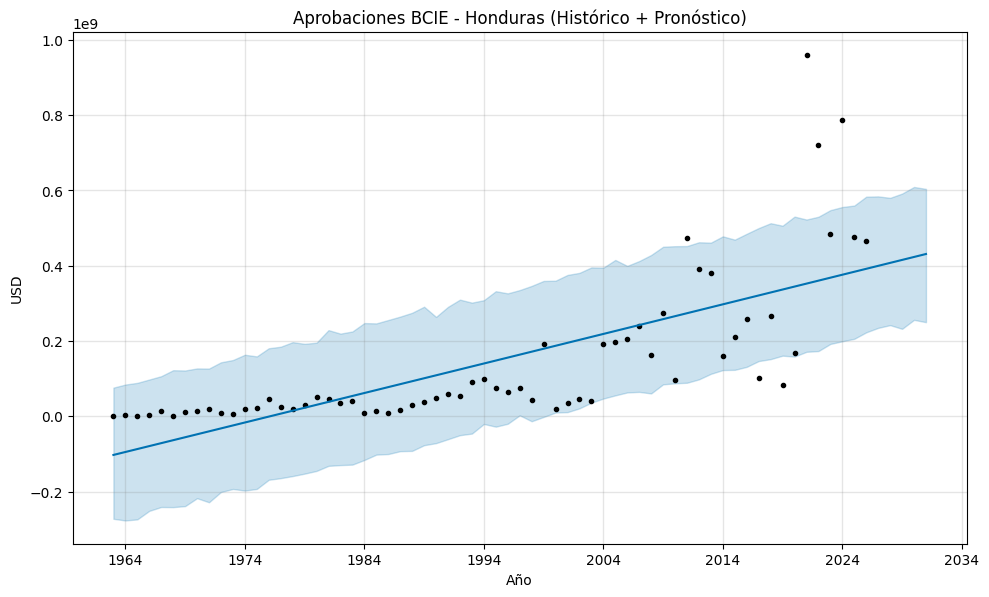

In [65]:
fig1 = m_pais.plot(forecast_pais)
plt.title(f"Aprobaciones BCIE - {PAIS_EJEMPLO} (Histórico + Pronóstico)")
plt.xlabel("Año")
plt.ylabel("USD")
plt.show()


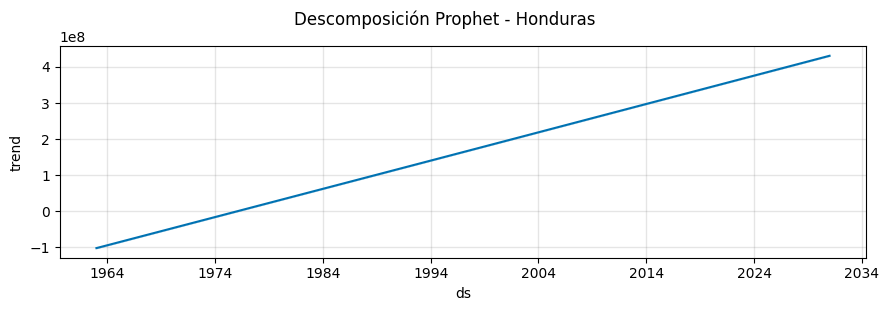

In [66]:
fig2 = m_pais.plot_components(forecast_pais)
plt.suptitle(f"Descomposición Prophet - {PAIS_EJEMPLO}", y=1.02)
plt.show()


In [67]:
# Guarda como PNG en buena resolución
fig2.savefig(f"results/prophet_componentes_{PAIS_EJEMPLO.lower().replace(' ', '_')}.png",
             dpi=200, bbox_inches="tight")


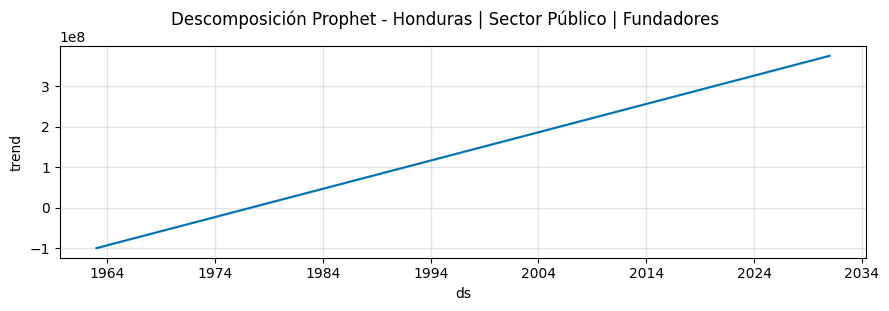

In [68]:
PAIS = "Honduras"
SECTOR = "Sector Público"          # ajusta a tus valores reales
TIPO = "Fundadores"                # ajusta a tus valores reales

historia = df_ml[
    (df_ml["País"] == PAIS) &
    (df_ml["Sector Institucional"] == SECTOR) &
    (df_ml["Tipo de Socio"] == TIPO)
].groupby("Año", as_index=False)["Monto Total (USD)"].sum().sort_values("Año")

df_prophet_seg = historia.rename(columns={"Año": "ds", "Monto Total (USD)": "y"}).copy()
df_prophet_seg["ds"] = pd.to_datetime(df_prophet_seg["ds"].astype(str) + "-12-31")

# ✅ APAGA estacionalidades porque la serie es anual
m_seg = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    interval_width=0.80
)

m_seg.fit(df_prophet_seg)

future_seg = m_seg.make_future_dataframe(periods=5, freq="Y")
forecast_seg = m_seg.predict(future_seg)

fig3 = m_seg.plot_components(forecast_seg)
plt.suptitle(f"Descomposición Prophet - {PAIS} | {SECTOR} | {TIPO}", y=1.02)
plt.show()
